In [1]:
import os 
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '1d_cnn-pytorch.ipynb',
 'Bayesian Neural Networks.ipynb',
 'build_stack_time_step_dataset.ipynb',
 'cnn-time-stack.ipynb',
 'data',
 'DataCleaning.ipynb',
 'EDA.ipynb',
 'feature select.ipynb',
 'img',
 'Impute_Missing_Value.ipynb',
 'LSTM.ipynb',
 'README.md',
 'second_model.ipynb',
 'spec_check&add_target.ipynb',
 'three_model.ipynb',
 'TimeSplit.ipynb',
 'xgboost.ipynb',
 '南亞PA廠資料分析_R6_1219.ipynb']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
from math import sqrt
import joblib

# load data

In [3]:
dataset = joblib.load('./data/dataset_for_cnn_model')
X = dataset['X'][:10000]
y = dataset['y'].iloc[:10000]
i_lst = dataset['index']

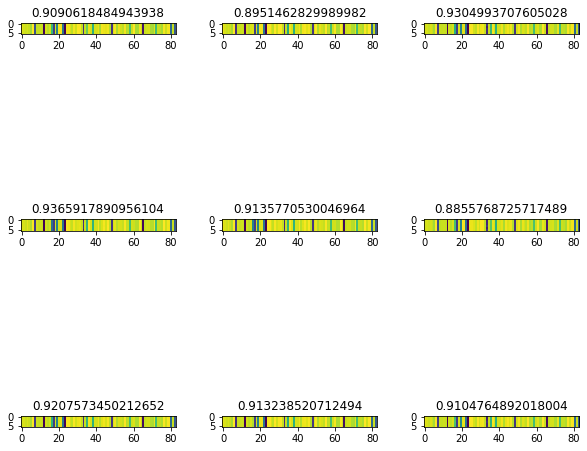

In [4]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X))
    plt.imshow(X[idx])
    plt.title(y[idx])

# reshape

In [5]:
TIME_PERIODS,num_sensors = X[0].shape
input_shape = TIME_PERIODS*num_sensors
X = X.reshape(-1,input_shape)
print(TIME_PERIODS,num_sensors)
print(input_shape)
print(X.shape,y.shape)

6 83
498
(10000, 498) (10000,)


# sklearn time split

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score

y_pred = []
tscv = TimeSeriesSplit().split(X,y)

t = 0
for train_index,test_index in tqdm(tscv):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit
    model = XGBRegressor(objective="reg:squarederror")
    model.fit(X_train, y_train)
    
    # predict
    if t == 0:
        y_pred.extend(model.predict(X_train))
    
    y_pred.extend(model.predict(X_test))
    
    t += 1

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [7]:
y_pred = pd.Series(y_pred,name='y_pred',index=y.index)
y_pred.head()

2016-05-23 15:20:00    0.887827
2016-05-23 15:30:00    0.887122
2016-05-23 15:40:00    0.887771
2016-05-23 15:50:00    0.893496
2016-05-23 16:00:00    0.892864
Name: y_pred, dtype: float64

# metric r2 and rmse

In [8]:
res = pd.DataFrame(columns=['R2','RMSE'])
tscv = TimeSeriesSplit().split(X,y)

for train_index,test_index in tscv:
    tag = str(y[test_index].index[0].date())+'~'+str(y[test_index].index[-1].date())
    res.loc[tag,'R2'] = r2_score(y[test_index],y_pred[test_index])
    res.loc[tag,'RMSE'] = sqrt(mean_squared_error(y[test_index],y_pred[test_index]))

In [9]:
res

,R2,RMSE
2016-06-07~2016-06-19,-1.21735,0.0155912
2016-06-19~2016-07-01,-2.28319,0.0219518
2016-07-01~2016-07-13,-0.994169,0.0115144
2016-07-13~2016-07-27,-0.202672,0.0146606
2016-07-27~2016-08-08,-0.162802,0.0112074


# plot

In [10]:
n = int(len(y)/100)
n

100

C:\Users\skywalker0803r\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


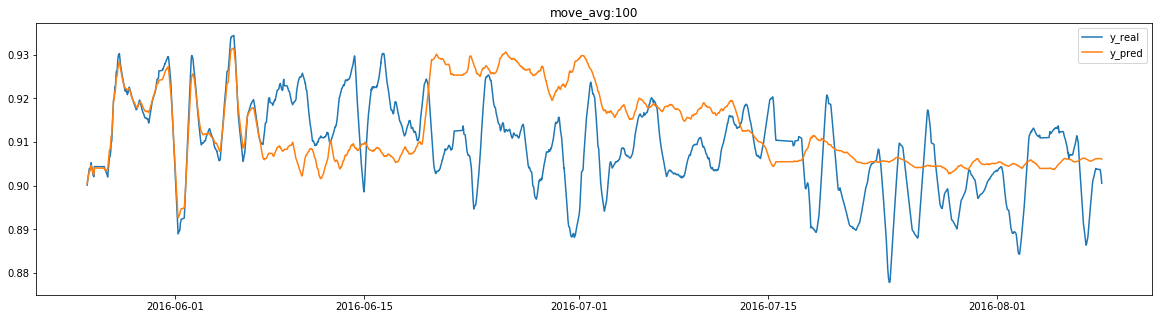

In [11]:
fig = plt.figure(figsize=(20,5))
plt.title('move_avg:{}'.format(n))
plt.plot(y.rolling(n).mean(),label='y_real')
plt.plot(y_pred.rolling(n).mean(),label='y_pred')
plt.legend()
plt.show()